In [1]:
from google.colab import drive
from google.colab import auth
from google.auth import default
import os

# Attempt to unmount the drive if it's already mounted and remove the directory
try:
  drive.flush_and_unmount()
except ValueError:
  pass # Drive was not mounted, continue

# Explicitly remove and recreate the mount point directory
if os.path.exists('/content/drive/'):
    os.system('rm -rf /content/drive/')
os.makedirs('/content/drive/', exist_ok=True)

drive.mount('/content/drive/', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive/


In [2]:
# Paths / hyperparams
CSV  = "/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/processed/metadata.csv"
RUNS = "/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs"
SIZE = 512
BATCH = 4
EPOCHS = 30
LR = 1e-3
SEED = 42

!pip -q install segmentation-models-pytorch==0.3.3 timm==0.9.2 albumentations==1.4.7 --no-cache-dir

import os, random, numpy as np, pandas as pd, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
os.makedirs(RUNS, exist_ok=True)

# Reproducibility
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 206.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 157.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 312.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 239.6 MB/s eta 0:00:00


'cuda'

### Load Metadata and Split for Segmentation

In [3]:
df = pd.read_csv(CSV)
seg_train = df.query("source=='aquavplant' and split=='train'").reset_index(drop=True)
seg_val   = df.query("source=='aquavplant' and split=='val'").reset_index(drop=True)

print("train pairs:", len(seg_train), " | val pairs:", len(seg_val))
seg_train.head(3)

train pairs: 148  | val pairs: 27


,image_path,mask_path,has_hyacinth,source,split,species_name,base_stem
0,/content/drive/MyDrive/HyacinthWatch_workspace...,/content/drive/MyDrive/HyacinthWatch_workspace...,1,aquavplant,train,NaN,NaN
1,/content/drive/MyDrive/HyacinthWatch_workspace...,/content/drive/MyDrive/HyacinthWatch_workspace...,1,aquavplant,train,NaN,NaN
2,/content/drive/MyDrive/HyacinthWatch_workspace...,/content/drive/MyDrive/HyacinthWatch_workspace...,1,aquavplant,train,NaN,NaN


Dataset & Loaders

In [4]:
# Albumentations pipelines (keep it sane to start)
train_tfms = A.Compose([
    A.LongestMaxSize(max_size=SIZE),
    A.PadIfNeeded(min_height=SIZE, min_width=SIZE, border_mode=0, value=(128,128,128), mask_value=0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.2),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05, p=0.3),
    A.GaussianBlur(blur_limit=(3,5), p=0.15),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

val_tfms = A.Compose([
    A.LongestMaxSize(max_size=SIZE),
    A.PadIfNeeded(min_height=SIZE, min_width=SIZE, border_mode=0, value=(128,128,128), mask_value=0),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

class AqSegDataset(Dataset):
    def __init__(self, frame, tfm):
        self.df = frame.reset_index(drop=True)
        self.tfm = tfm
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = np.array(Image.open(r.image_path).convert("RGB"))
        msk = np.array(Image.open(r.mask_path).convert("L"))
        # ensure binary {0,1}
        if msk.max() > 1:
            msk = (msk > 127).astype("uint8")
        aug = self.tfm(image=img, mask=msk)
        x = aug["image"]                    # [3,H,W] float32 normalized
        y = aug["mask"][None, ...].float()  # [1,H,W] in {0,1}
        return x, y

dl_tr = DataLoader(AqSegDataset(seg_train, train_tfms), batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
dl_va = DataLoader(AqSegDataset(seg_val,   val_tfms),   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

xb, mb = next(iter(dl_tr))
xb.shape, mb.shape, xb.dtype, mb.dtype

/usr/local/lib/python3.12/dist-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `float` - serialized value may not be as expected [input_value=[0.8, 1.2], input_type=list])
  PydanticSerializationUnexpectedValue(Expected `tuple[float, float]` - serialized value may not be as expected [input_value=[0.8, 1.2], input_type=list])
  PydanticSerializationUnexpectedValue(Expected `float` - serialized value may not be as expected [input_value=[0.8, 1.2], input_type=list])
  PydanticSerializationUnexpectedValue(Expected `tuple[float, float]` - serialized value may not be as expected [input_value=[0.8, 1.2], input_type=list])
  PydanticSerializationUnexpectedValue(Expected `float` - serialized value may not be as expected [input_value=[0.9, 1.1], input_type=list])
  PydanticSerializationUnexpectedValue(Expected `tuple[float, float]` - serialized value may not be as expected [input_value=[0.9, 1.1], input_type=list])
  Pydan

(torch.Size([4, 3, 512, 512]),
 torch.Size([4, 1, 512, 512]),
 torch.float32,
 torch.float32)

### Model (U-Net with ResNet-34 encoder, pretrained)

In [5]:
# Pretrained encoder on ImageNet
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

# Loss: BCE + Dice
bce = nn.BCEWithLogitsLoss()

def dice_loss(logits, target, eps=1e-7):
    prob = torch.sigmoid(logits)
    inter = (prob*target).sum(dim=(1,2,3))
    den   = prob.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    return 1 - ((2*inter + eps)/(den + eps)).mean()

def combo_loss(logits, target):
    return 0.5 * bce(logits, target) + 0.5 * dice_loss(logits, target)

opt = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3)

scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 141MB/s]
/tmp/ipython-input-1456953116.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


### Train/Val loops (mixed precision) + IoU/Dice



In [6]:
import math, time

@torch.no_grad()
def eval_epoch(model, loader, device, thresh=0.5):
    model.eval()
    total_loss = 0.0; n = 0
    ious=[]; dices=[]
    for xb, mb in loader:
        xb, mb = xb.to(device, non_blocking=True), mb.to(device, non_blocking=True)
        logits = model(xb)
        loss = combo_loss(logits, mb)
        total_loss += loss.item() * xb.size(0); n += xb.size(0)

        prob = torch.sigmoid(logits)
        pred = (prob > thresh).float()
        # IoU
        inter = (pred*mb).sum(dim=(1,2,3))
        union = pred.sum(dim=(1,2,3)) + mb.sum(dim=(1,2,3)) - inter
        iou = ((inter+1e-7)/(union+1e-7)).detach().cpu().numpy()
        ious.extend(iou.tolist())
        # Dice
        dice = (2*inter+1e-7)/(pred.sum(dim=(1,2,3))+mb.sum(dim=(1,2,3))+1e-7)
        dices.extend(dice.detach().cpu().numpy().tolist())
    return total_loss/max(n,1), float(np.mean(ious)), float(np.mean(dices))

def train_epoch(model, loader, device):
    model.train()
    total_loss=0.0; n=0
    for xb, mb in loader:
        xb, mb = xb.to(device, non_blocking=True), mb.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            logits = model(xb)
            loss = combo_loss(logits, mb)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        total_loss += loss.item()*xb.size(0); n += xb.size(0)
    return total_loss/max(n,1)

### Train (save best by val loss) and report metrics

In [7]:
best_loss = float("inf")
best_path = f"{RUNS}/unet_resnet34_aquavplant.pt"
history = []

for ep in range(1, EPOCHS+1):
    tr_loss = train_epoch(model, dl_tr, device)
    va_loss, va_iou, va_dice = eval_epoch(model, dl_va, device, thresh=0.5)
    sched.step(va_loss)
    history.append((ep, tr_loss, va_loss, va_iou, va_dice))
    print(f"Epoch {ep:02d} | train {tr_loss:.4f} | val {va_loss:.4f} | IoU {va_iou:.4f} | Dice {va_dice:.4f} | lr {opt.param_groups[0]['lr']:.2e}")
    if va_loss < best_loss:
        best_loss = va_loss
        torch.save(model.state_dict(), best_path)
        print("  ↳ saved:", best_path)

print("Best val loss:", best_loss)

/tmp/ipython-input-1636967896.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 01 | train 0.5384 | val 0.5211 | IoU 0.3975 | Dice 0.5351 | lr 1.00e-03
  ↳ saved: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs/unet_resnet34_aquavplant.pt
Epoch 02 | train 0.3764 | val 0.3706 | IoU 0.4492 | Dice 0.5883 | lr 1.00e-03
  ↳ saved: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs/unet_resnet34_aquavplant.pt
Epoch 03 | train 0.3210 | val 0.3450 | IoU 0.4905 | Dice 0.6206 | lr 1.00e-03
  ↳ saved: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs/unet_resnet34_aquavplant.pt
Epoch 04 | train 0.2757 | val 0.3437 | IoU 0.4628 | Dice 0.5992 | lr 1.00e-03
  ↳ saved: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs/unet_resnet34_aquavplant.pt
Epoch 05 | train 0.2777 | val 0.3114 | IoU 0.4871 | Dice 0.6274 | lr 1.00e-03
  ↳ saved: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs/unet_resnet34_aquavplant.pt
Epoch 06 | train 0.2599 | val 0.3667 | IoU 0.4200 | Dice 0.5

### Reload best and do a threshold sweep

In [8]:
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

def sweep_thresholds(model, loader, device, ts=(0.3,0.4,0.5,0.6)):
    vals=[]
    for t in ts:
        _, iou, dice = eval_epoch(model, loader, device, thresh=t)
        vals.append((t, iou, dice))
    return vals

vals = sweep_thresholds(model, dl_va, device, ts=(0.30,0.40,0.50,0.60))
print({f"{t:.2f}": round(iou,4) for t, iou, _ in vals})
print("Dice:", {f"{t:.2f}": round(d,4) for t, _, d in vals})

{'0.30': 0.6151, '0.40': 0.6186, '0.50': 0.6207, '0.60': 0.6219}
Dice: {'0.30': 0.7333, '0.40': 0.7372, '0.50': 0.74, '0.60': 0.7419}


### Quick inline visualization (k examples)

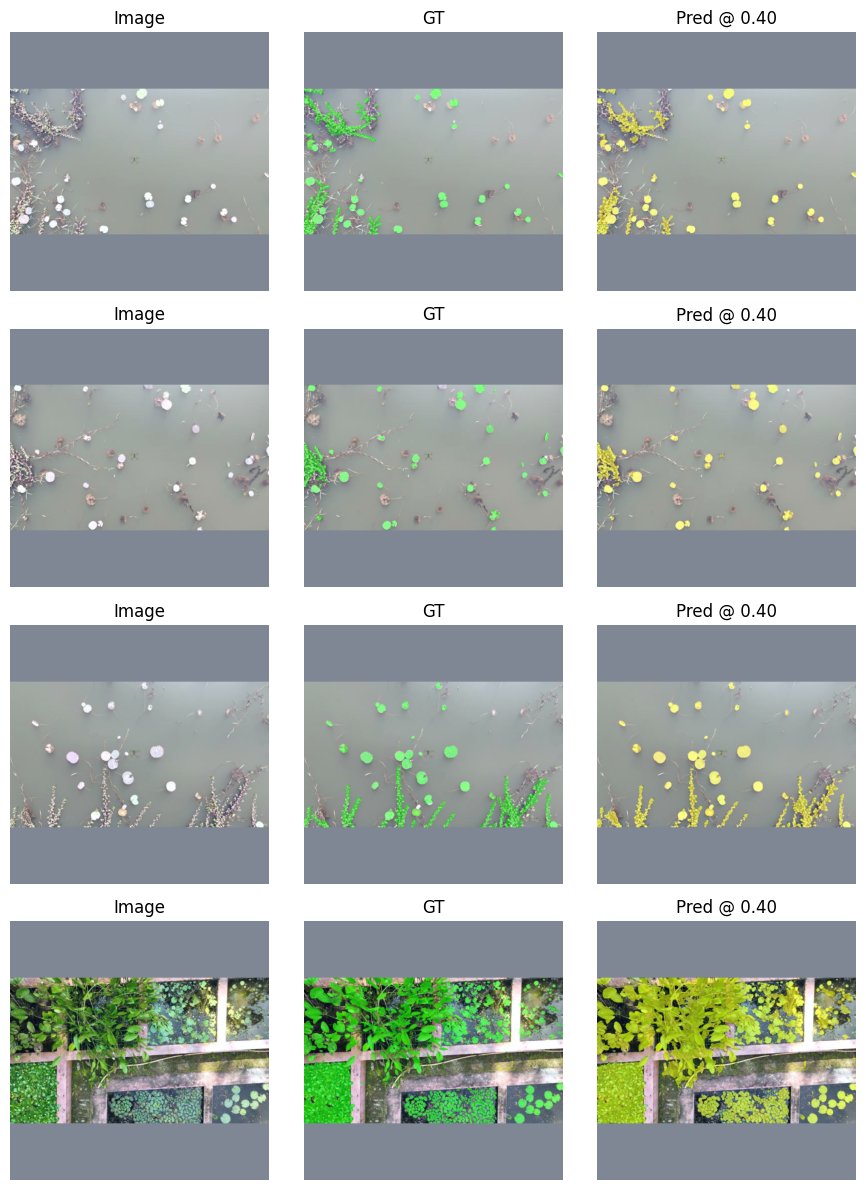

In [9]:
import matplotlib.pyplot as plt

def _overlay(img01, mask01, color=(1,1,0), alpha=0.45):
    img = img01.copy()
    c = np.array(color)[None,None,:]
    return np.clip((1 - alpha*mask01[...,None])*img + alpha*mask01[...,None]*c, 0, 1)

@torch.no_grad()
def show_seg_samples(model, loader, device, k=4, thresh=0.5):
    model.eval()
    xb, mb = next(iter(loader))
    xb, mb = xb.to(device), mb.to(device)
    logits = model(xb)
    prob = torch.sigmoid(logits)
    pred = (prob > thresh).float()

    k = min(k, xb.size(0))
    plt.figure(figsize=(9, 3*k))
    for i in range(k):
        img = xb[i].detach().cpu().permute(1,2,0).numpy()
        gt  = mb[i].detach().cpu().squeeze().numpy()
        pr  = pred[i].detach().cpu().squeeze().numpy()
        ax = plt.subplot(k,3,3*i+1); ax.imshow((img*0.229+0.485).clip(0,1)); ax.axis("off"); ax.set_title("Image")
        ax = plt.subplot(k,3,3*i+2); ax.imshow(_overlay((img*0.229+0.485).clip(0,1), gt, (0,1,0))); ax.axis("off"); ax.set_title("GT")
        ax = plt.subplot(k,3,3*i+3); ax.imshow(_overlay((img*0.229+0.485).clip(0,1), pr, (1,1,0))); ax.axis("off"); ax.set_title(f"Pred @ {thresh:.2f}")
    plt.tight_layout(); plt.show()

# usage:
show_seg_samples(model, dl_va, device, k=4, thresh=0.4)  # try best threshold from sweep